In [1]:
import os
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal

In [2]:
ds = pd.read_csv('Data/Sheep/Sheep.csv', sep=',')

In [4]:
ds.head(2)

,Unnamed: 0,label,animal_ID,segment_ID,timestamp_ms,ax,ay,az,axhg,ayhg,azhg,cx,cy,cz,gx,gy,gz,pressure,temp
0,0,walking,S1,1,1,-2.73178,-6.68701,-6.57208,2.13233,-5.37588,17.8696,1.5525,-0.4755,0.5415,2.012200,-51.3415,-32.6220,NaN,27.38
1,1,walking,S1,1,6,-2.78206,-6.82347,-6.62954,1.71187,-3.27358,17.3290,NaN,NaN,NaN,-0.121951,-47.3171,-33.5366,NaN,27.39


In [5]:
ds.shape

(4965600, 19)

In [8]:
ds[ds['segment_ID'] == 1]

,Unnamed: 0,label,animal_ID,segment_ID,timestamp_ms,ax,ay,az,axhg,ayhg,azhg,cx,cy,cz,gx,gy,gz,pressure,temp
0,0,walking,S1,1,1,-2.73178,-6.68701,-6.57208,2.13233,-5.37588,17.869600,1.5525,-0.4755,0.5415,2.012200,-51.34150,-32.6220,NaN,27.38
1,1,walking,S1,1,6,-2.78206,-6.82347,-6.62954,1.71187,-3.27358,17.329000,NaN,NaN,NaN,-0.121951,-47.31710,-33.5366,NaN,27.39
2,2,walking,S1,1,11,-2.82755,-6.96713,-6.54814,3.09339,-3.63398,17.028600,1.5405,-0.4785,0.5655,-1.890240,-42.56100,-35.0000,NaN,27.39
3,3,walking,S1,1,16,-2.85149,-7.14669,-6.47871,1.65181,-4.41483,18.229900,NaN,NaN,NaN,-3.109760,-37.74390,-36.6463,1008.22,27.36
4,4,walking,S1,1,21,-2.89220,-7.30710,-6.37815,1.17128,-3.45378,16.548100,1.5405,-0.4785,0.5655,-2.987800,-33.04880,-38.3537,NaN,27.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2389107,2389107,walking,S2,1,5561,5.46117,8.54251,-7.40048,7.08776,15.61710,3.603940,NaN,NaN,NaN,31.646300,-8.65854,19.6951,1007.13,28.49
2389108,2389108,walking,S2,1,5566,5.21218,8.57364,-7.40048,4.92539,11.62270,-0.090099,-1.4520,0.0840,1.2150,28.719500,-9.57317,22.0732,NaN,28.47
2389109,2389109,walking,S2,1,5571,4.88896,8.57603,-7.35020,4.80526,11.08210,0.600657,NaN,NaN,NaN,26.768300,-10.24390,24.5732,NaN,28.48
2389110,2389110,walking,S2,1,5576,4.45800,8.56885,-7.29034,8.46927,12.25340,1.021120,-1.4400,0.0840,1.2120,25.487800,-10.48780,27.5610,NaN,28.47


There are 679 segments present in the following dataset.

Analyzing a segment and it's label.

In [129]:
ds_seg = ds[ds.segment_ID==1]

Here there are 1572 data points in this segment. 

Let's check if the timestamp is continuous.

In [54]:
def checkTimeStampContinuous(TimeSeries):
    if (TimeSeries.diff().unique()[1] == 5.0):
        return True
    else:
        False
checkTimeStampContinuous(ds_seg['timestamp_ms'])

True

Let's find out the number of data points present in each segment.

[]

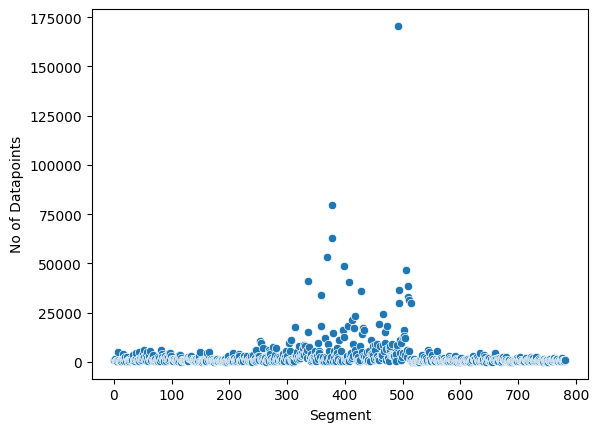

In [55]:
points_per_segment = []

for segment in ds['segment_ID'].unique():
    points_per_segment.append(ds[ds['segment_ID']==segment].shape[0])

sns.scatterplot(x=ds['segment_ID'].unique(),y = points_per_segment)
plt.xlabel('Segment')
plt.ylabel('No of Datapoints')
plt.plot()

Since each segment has uneven number of data points, we have to now check if the data points in each segment have the same label.


In [56]:
def labelCheck(segmentLabelSeries):
    if(len(segmentLabelSeries.unique())==1):
        return True
    else:
        False

for segment in ds['segment_ID'].unique():
    if(labelCheck(ds[ds['segment_ID']==segment]['label'])):
        pass
    else:
        print('Segment {} has a different label set.'.format(segment))

print("Check Completed!")


Check Completed!


Segment Visualization

782
walking     244
standing    234
trotting    131
grazing      83
running      83
shaking       5
fighting      2
Name: count, dtype: int64


Text(0, 0.5, 'Labels')

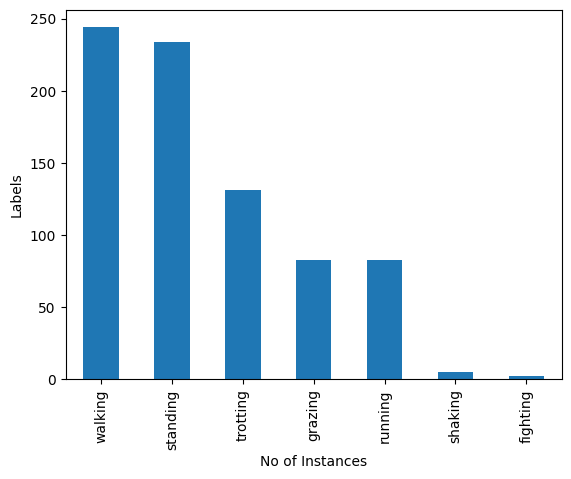

In [59]:
label_per_segment = []

for segment in ds['segment_ID'].unique():
    label_per_segment.append(ds[ds['segment_ID']==segment]['label'].unique()[0])


print(len(label_per_segment))
print(pd.Series(label_per_segment).value_counts())

pd.Series(label_per_segment).value_counts().plot(kind='bar')
plt.xlabel('No of Instances')
plt.ylabel('Labels')

[]

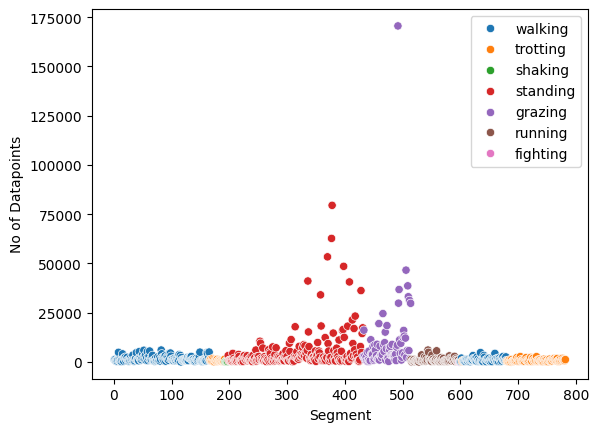

In [60]:
points_per_segment = []
label_per_segment = []

for segment in ds['segment_ID'].unique():
    points_per_segment.append(ds[ds['segment_ID']==segment].shape[0])
    label_per_segment.append(ds[ds['segment_ID']==segment]['label'].unique()[0])

sns.scatterplot(x=ds['segment_ID'].unique(),y = points_per_segment,hue=label_per_segment)
plt.xlabel('Segment')
plt.ylabel('No of Datapoints')
plt.plot()

We can see from the above plot, that the classes are imbalanced. These are the observations:
1. There is only one data point for fighting. So we can not include this in the model for training.
2. The classes standing and shaking appear to be similar, will have to find some evidence to merge the two data points.
3. Technically, the act of grazing and walking can be considered similar, since both sheep usually graze the field walking. (Will need to look into this as well.)


Let's analyse each segments signals to deduce the fluctuation among different classes.

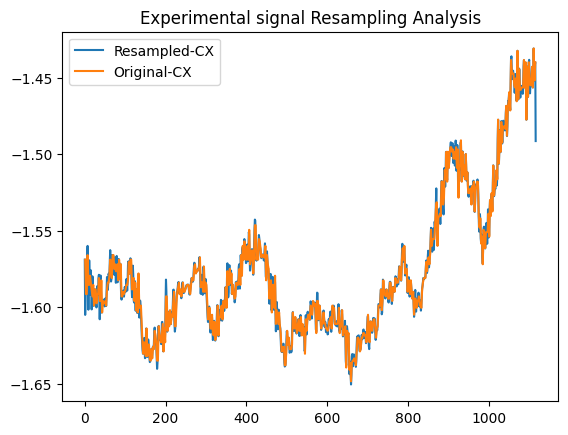

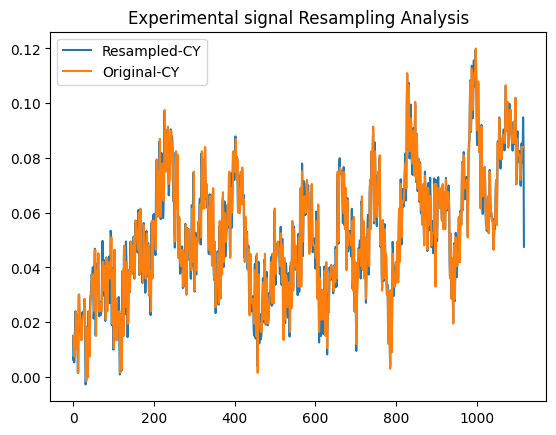

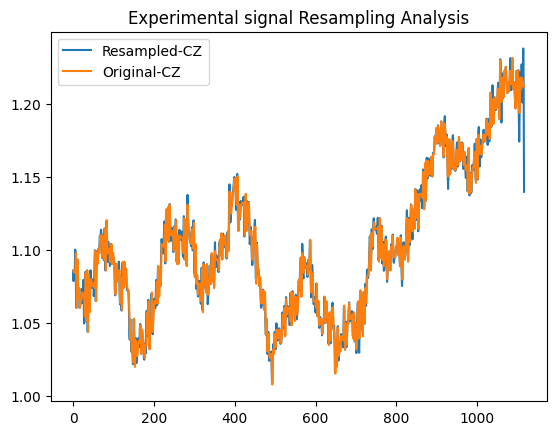

-1.5750645161290322


In [90]:
# Experimental Signal Resampling
segment = 1
pd.Series(signal.resample(ds[ds['segment_ID']==segment]['cx'].dropna(),ds[ds['segment_ID']==segment].shape[0])).plot(label='Resampled-CX')
ds[ds['segment_ID']==segment]['cx'].dropna().plot(label='Original-CX')
plt.title("Experimental signal Resampling Analysis")
plt.legend()
plt.show()
pd.Series(signal.resample(ds[ds['segment_ID']==segment]['cy'].dropna(),ds[ds['segment_ID']==segment].shape[0])).plot(label='Resampled-CY')
ds[ds['segment_ID']==segment]['cy'].dropna().plot(label='Original-CY')
plt.title("Experimental signal Resampling Analysis")
plt.legend()
plt.show()
pd.Series(signal.resample(ds[ds['segment_ID']==segment]['cz'].dropna(),ds[ds['segment_ID']==segment].shape[0])).plot(label='Resampled-CZ')
ds[ds['segment_ID']==segment]['cz'].dropna().plot(label='Original-CZ')
plt.title("Experimental signal Resampling Analysis")
plt.legend()
plt.show()

print(pd.Series(signal.resample(ds[ds['segment_ID']==segment]['cx'].dropna(),ds[ds['segment_ID']==segment].shape[0])).mean())

### Feature Extraction
* Accelerometer Feature
    *   Acceleration
        * Deriving acceleration from accelerometer readings.
        * acceleration = sqrt((ax^2)+(ay^2)+(az^2))
        * Can be applied to High Intensity Accelerometer as well.\
    * %change of Acceleration with time (Average/Segment)
* Magnetometer/Compass
    * Heading Feature
        * Arctan2(y,x)
        * Calculates the tangent angle between the X co-ordinate and Y co-ordinate.
    * %change of Heading with time (Mod|Heading|/Segment)
    


In [177]:
# Experiment on segment
ds_seg_fight = ds[ds.segment_ID == 198]
ds_seg_walk = ds[ds.segment_ID == 1]

ds_seg_fight['acceleration'] = np.sqrt((ds_seg_fight['ax']**2)+(ds_seg_fight['ay']**2)+(ds_seg_fight['az']**2))
ds_seg_walk['acceleration'] = np.sqrt((ds_seg_walk['ax']**2)+(ds_seg_walk['ay']**2)+(ds_seg_walk['az']**2))

ds_seg_fight['acc_change_percent'] = ds_seg_fight['acceleration'].pct_change()*100
ds_seg_walk['acc_change_percent'] = ds_seg_walk['acceleration'].pct_change()*100

C:\Users\shara\AppData\Local\Temp\ipykernel_13620\170461144.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds_seg_fight['acceleration'] = np.sqrt((ds_seg_fight['ax']**2)+(ds_seg_fight['ay']**2)+(ds_seg_fight['az']**2))
C:\Users\shara\AppData\Local\Temp\ipykernel_13620\170461144.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds_seg_walk['acceleration'] = np.sqrt((ds_seg_walk['ax']**2)+(ds_seg_walk['ay']**2)+(ds_seg_walk['az']**2))
C:\Users\shara\AppData\Local\Temp\ipykernel_13620\170461144.py:8: Se

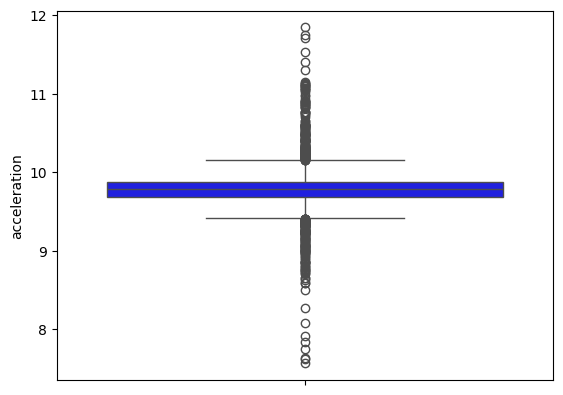

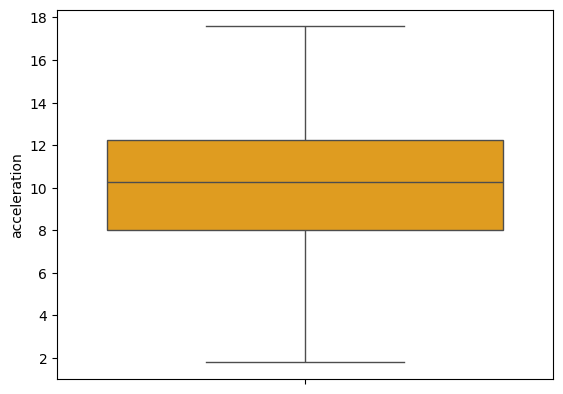

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


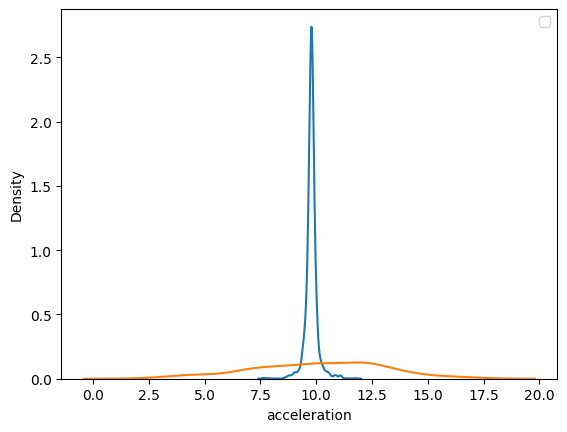

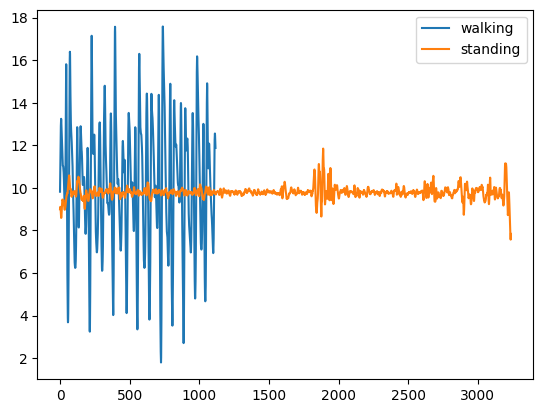

In [178]:
# Visualization on Acceleration Feature
sns.boxplot(ds_seg_fight['acceleration'],color='blue')
plt.show()
sns.boxplot(ds_seg_walk['acceleration'],color='orange')
plt.show()

sns.kdeplot(ds_seg_fight['acceleration'])
sns.kdeplot(ds_seg_walk['acceleration'])
plt.legend()
plt.show()
ds_seg_walk['acceleration'].plot(label='walking')
ds_seg_fight['acceleration'].reset_index(drop=True).plot(label='standing')
plt.legend()
plt.show()


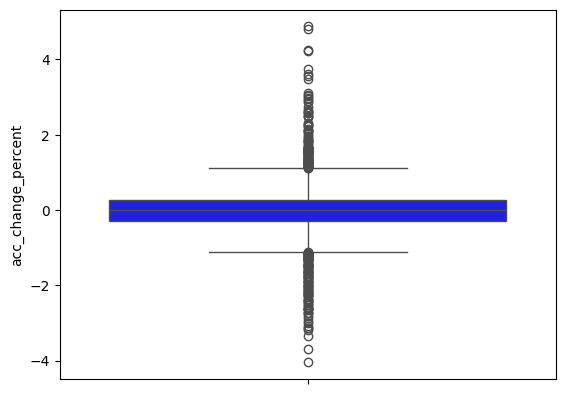

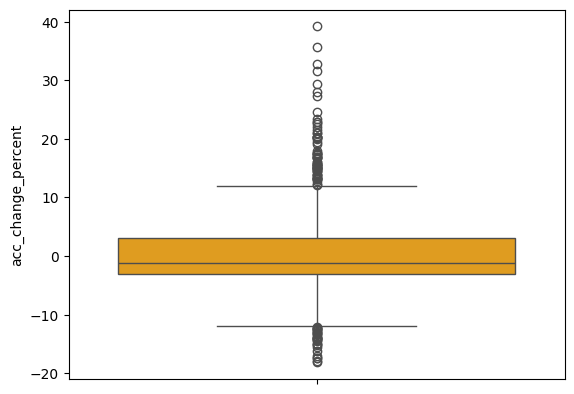

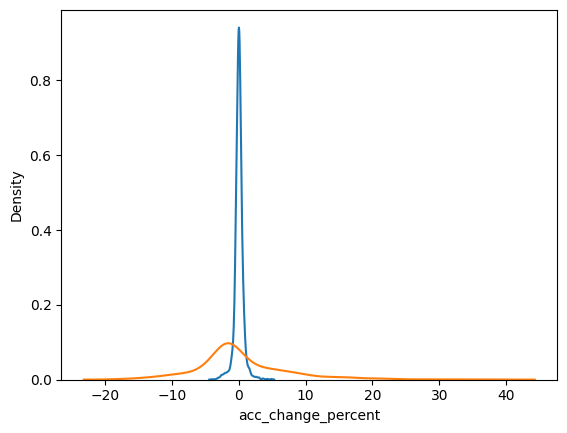

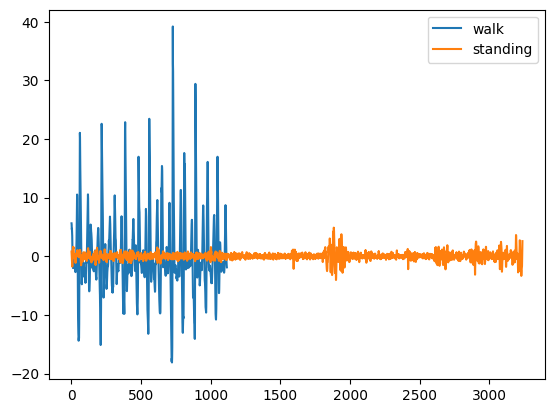

Acceleration Change(%) Standing: -0.002009720038820826
Acceleration Change(%) Walking: 0.24793884069681643


In [196]:
# Visualization of Acceleration_%_change Feature
sns.boxplot(ds_seg_fight['acc_change_percent'],color='blue')
plt.show()
sns.boxplot(ds_seg_walk['acc_change_percent'],color='orange')
plt.show()

sns.kdeplot(ds_seg_fight['acc_change_percent'])
sns.kdeplot(ds_seg_walk['acc_change_percent'])
plt.show()
ds_seg_walk['acc_change_percent'].plot(label='walk')
ds_seg_fight['acc_change_percent'].reset_index(drop=True).plot(label='standing')
plt.legend()
plt.show()

print("Acceleration Change(%) Standing: {}".format(ds_seg_fight['acc_change_percent'].dropna().mean()))
print("Acceleration Change(%) Walking: {}".format(ds_seg_walk['acc_change_percent'].dropna().mean()))

Let's apply this on the entire dataset.

In [197]:
print(ds_seg_walk['acceleration'].diff().abs().mean())
print(ds_seg_fight['acceleration'].diff().abs().mean())

print(ds_seg_walk['acceleration'].mean())
print(ds_seg_fight['acceleration'].mean())

0.42419308086908447
0.04211084292269102
10.101605946401989
9.786245802105126


### Signal-Segment synthesis

In [92]:
ax_avg = []
ay_avg = []
az_avg = []
axhg_avg = []
ayhg_avg = []
azhg_avg = []
cx_avg = []
cy_avg = []
cz_avg = []
temp_avg = []
press_avg = []
label = []
segment_id = []
for segment in ds['segment_ID'].unique():
    segment_id.append(segment)
    ax_avg.append(ds[ds['segment_ID']==segment]['ax'].mean())
    ay_avg.append(ds[ds['segment_ID']==segment]['ay'].mean())
    az_avg.append(ds[ds['segment_ID']==segment]['az'].mean())

    axhg_avg.append(ds[ds['segment_ID']==segment]['axhg'].mean())
    ayhg_avg.append(ds[ds['segment_ID']==segment]['ayhg'].mean())
    azhg_avg.append(ds[ds['segment_ID']==segment]['azhg'].mean())

    cx_avg.append(pd.Series(signal.resample(ds[ds['segment_ID']==segment]['cx'].dropna(),ds[ds['segment_ID']==segment].shape[0])).mean())
    cy_avg.append(pd.Series(signal.resample(ds[ds['segment_ID']==segment]['cy'].dropna(),ds[ds['segment_ID']==segment].shape[0])).mean())
    cz_avg.append(pd.Series(signal.resample(ds[ds['segment_ID']==segment]['cz'].dropna(),ds[ds['segment_ID']==segment].shape[0])).mean())

    temp_avg.append(ds[ds['segment_ID']==segment]['temp'].mean())
    press_avg.append(ds[ds['segment_ID']==segment]['pressure'].mean())
    label.append(ds[ds['segment_ID']==segment]['label'].unique()[0])



synthesized_df = pd.DataFrame({'segment_id':segment_id,
                                'ax_avg':ax_avg,
                                'ay_avg':ay_avg,
                                'az_avg':az_avg,
                                'axhg_avg':axhg_avg,
                                'ayhg_avg':ayhg_avg,
                                'azhg_avg':azhg_avg,
                                'cx_avg':cx_avg,
                                'cy_avg':cy_avg,
                                'cz_avg':cz_avg,
                                'temp_avg':temp_avg,
                                'press_avg':press_avg,
                                'label':label})

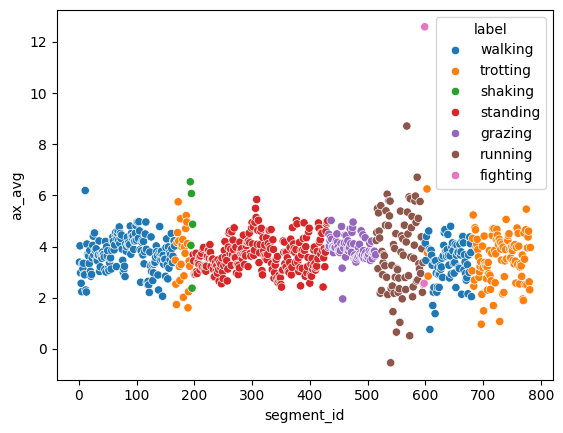

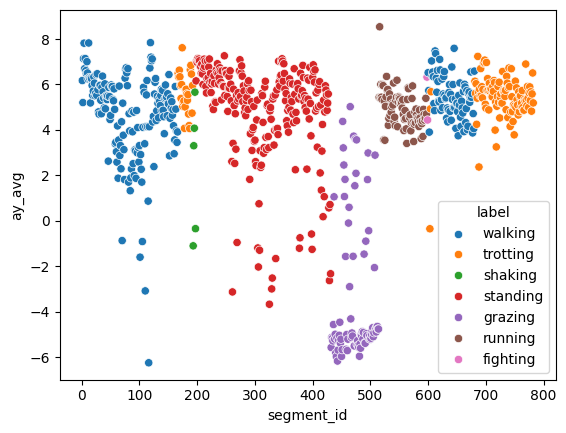

<Axes: xlabel='segment_id', ylabel='az_avg'>

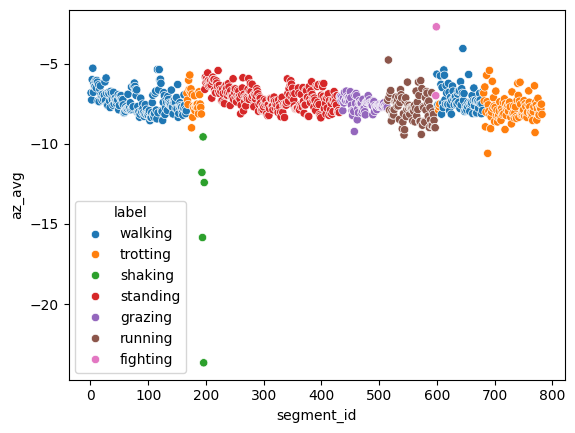

In [117]:
sns.scatterplot(y=synthesized_df['ax_avg'],x=synthesized_df['segment_id'],hue=synthesized_df.label)
plt.show()
sns.scatterplot(y=synthesized_df['ay_avg'],x=synthesized_df['segment_id'],hue=synthesized_df.label)
plt.show()
sns.scatterplot(y=synthesized_df['az_avg'],x=synthesized_df['segment_id'],hue=synthesized_df.label)

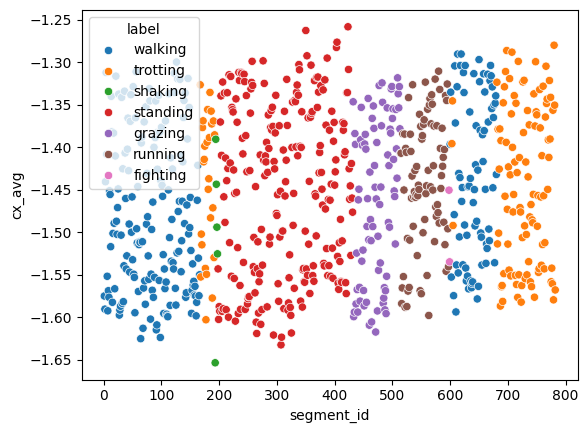

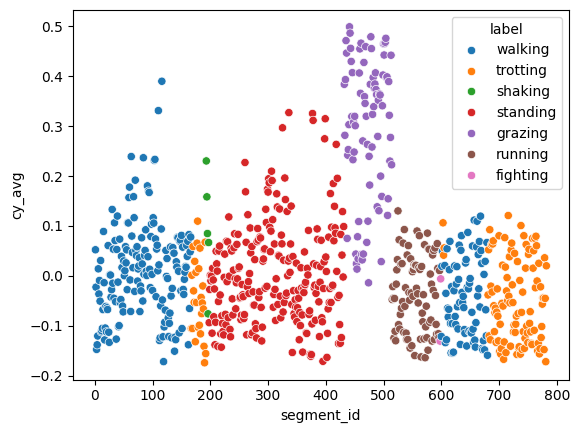

<Axes: xlabel='segment_id', ylabel='cz_avg'>

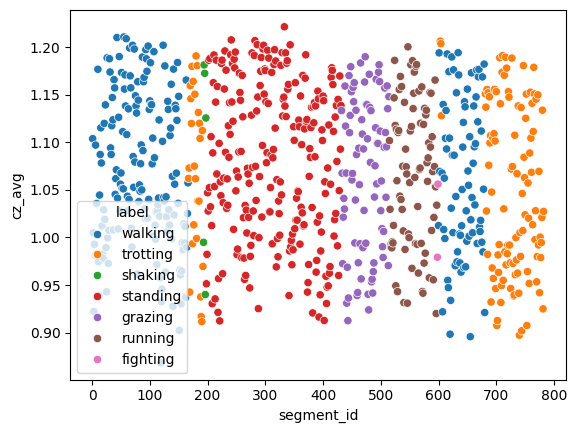

In [113]:
sns.scatterplot(y=synthesized_df['cx_avg'],x=synthesized_df['segment_id'],hue=synthesized_df.label)
plt.show()
sns.scatterplot(y=synthesized_df['cy_avg'],x=synthesized_df['segment_id'],hue=synthesized_df.label)
plt.show()
sns.scatterplot(y=synthesized_df['cz_avg'],x=synthesized_df['segment_id'],hue=synthesized_df.label)

In [1]:
import 

ModuleNotFoundError: No module named 'pymongo'